# preparation

In [43]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [44]:
DEVICE = "cuda:0"
BATCH_SIZE = 4
DATA_PATH = "/content/drive/MyDrive/hymenoptera_data/"
TESTDATA_PATH  = "/content/drive/MyDrive/hymenoptera_data/val/"
BASE_MODEL_PATH = "/content/drive/MyDrive/CNNOptimized.pth"
BEST_MODEL_PATH = "/content/drive/MyDrive/CNNPrunedFO"

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# image transformer
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

testset = torchvision.datasets.ImageFolder(TESTDATA_PATH, transform=data_transforms['val'])
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=4)

# define function

In [84]:
def test_model(model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

In [85]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        # save best model to local for further reuse
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    return model

In [86]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [87]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [88]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

# main function

load base model

In [89]:
# initialize
model = models.alexnet()

num_ftrs = model.classifier[-1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.classifier[-1] = nn.Linear(num_ftrs, 2)

# load base model
model.load_state_dict(torch.load(BASE_MODEL_PATH))

model = model.to(DEVICE)

prune the first conv layer of base model

In [90]:
# get the first convolutional layer of CNNOptimized
prune_module = model.features[0]

print(prune_module.weight)

Parameter containing:
tensor([[[[ 1.1885e-01,  9.4279e-02,  9.5671e-02,  ...,  5.6055e-02,
            2.1770e-02,  5.0097e-02],
          [ 7.5090e-02,  3.9192e-02,  5.3237e-02,  ...,  2.5938e-02,
           -1.1091e-02,  4.3139e-03],
          [ 7.5661e-02,  3.9052e-02,  5.5215e-02,  ...,  4.3822e-02,
            1.0423e-02,  1.3405e-02],
          ...,
          [ 9.3431e-02,  1.0397e-01,  6.7722e-02,  ..., -2.0287e-01,
           -1.2843e-01, -1.1219e-01],
          [ 4.3767e-02,  6.5096e-02,  3.6302e-02,  ..., -2.0256e-01,
           -1.1380e-01, -1.0722e-01],
          [ 4.7501e-02,  6.2653e-02,  2.4841e-02,  ..., -1.1851e-01,
           -9.5627e-02, -8.3904e-02]],

         [[-7.2375e-02, -5.7731e-02, -8.0362e-02,  ..., -2.9797e-04,
           -2.5048e-02,  2.5694e-02],
          [-6.8771e-02, -6.7252e-02, -7.6042e-02,  ..., -3.6626e-03,
           -3.0129e-02,  1.0731e-02],
          [-9.9225e-02, -8.5264e-02, -1.0487e-01,  ..., -2.6307e-02,
           -2.2521e-02,  6.8882e-03]

In [91]:
# randomly prune 30% of the connections in the parameter named weight in the first layer
prune.random_unstructured(prune_module, name="weight", amount=0.3)
model.features[0] = prune_module

print(prune_module.weight)

tensor([[[[ 0.0000e+00,  9.4279e-02,  9.5671e-02,  ...,  5.6055e-02,
            2.1770e-02,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  5.3237e-02,  ...,  0.0000e+00,
           -0.0000e+00,  4.3139e-03],
          [ 7.5661e-02,  0.0000e+00,  5.5215e-02,  ...,  0.0000e+00,
            1.0423e-02,  1.3405e-02],
          ...,
          [ 9.3431e-02,  1.0397e-01,  0.0000e+00,  ..., -2.0287e-01,
           -1.2843e-01, -0.0000e+00],
          [ 4.3767e-02,  6.5096e-02,  3.6302e-02,  ..., -2.0256e-01,
           -1.1380e-01, -0.0000e+00],
          [ 4.7501e-02,  6.2653e-02,  2.4841e-02,  ..., -1.1851e-01,
           -9.5627e-02, -8.3904e-02]],

         [[-7.2375e-02, -5.7731e-02, -8.0362e-02,  ..., -0.0000e+00,
           -0.0000e+00,  2.5694e-02],
          [-6.8771e-02, -6.7252e-02, -7.6042e-02,  ..., -0.0000e+00,
           -3.0129e-02,  1.0731e-02],
          [-9.9225e-02, -8.5264e-02, -1.0487e-01,  ..., -2.6307e-02,
           -0.0000e+00,  6.8882e-03],
          ...,
     

inference

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the validation images: 75 %


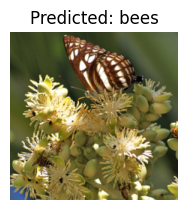

In [92]:
test_model(model)
visualize_model_predictions(
    model,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

retrain the model

In [93]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.3510 Acc: 0.8320
val Loss: 0.4114 Acc: 0.8497

Epoch 1/29
----------
train Loss: 0.2689 Acc: 0.9016
val Loss: 0.3451 Acc: 0.8693

Epoch 2/29
----------
train Loss: 0.2986 Acc: 0.8566
val Loss: 0.3220 Acc: 0.8889

Epoch 3/29
----------
train Loss: 0.2191 Acc: 0.9098
val Loss: 0.3195 Acc: 0.8954

Epoch 4/29
----------
train Loss: 0.1665 Acc: 0.9262
val Loss: 0.3817 Acc: 0.8431

Epoch 5/29
----------
train Loss: 0.1720 Acc: 0.9303
val Loss: 0.3500 Acc: 0.8824

Epoch 6/29
----------
train Loss: 0.1710 Acc: 0.9262
val Loss: 0.4495 Acc: 0.8497

Epoch 7/29
----------
train Loss: 0.1946 Acc: 0.9139
val Loss: 0.3264 Acc: 0.8758

Epoch 8/29
----------
train Loss: 0.1310 Acc: 0.9426
val Loss: 0.3161 Acc: 0.8954

Epoch 9/29
----------
train Loss: 0.1607 Acc: 0.9344
val Loss: 0.3033 Acc: 0.9085

Epoch 10/29
----------
train Loss: 0.1488 Acc: 0.9344
val Loss: 0.3019 Acc: 0.9150

Epoch 11/29
----------
train Loss: 0.1335 Acc: 0.9549
val Loss: 0.3062 Acc: 0.9150

Ep

inference

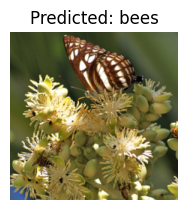

In [94]:
visualize_model_predictions(
    model,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()